# 유역별 수질 및 기상자료 분석


### 1. 라이브러리 로드 및 계절 정의 함수

In [214]:
# 라이브러리 로드
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# 파일 내보내기위한 라이브러리
from pathlib import Path
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# 시각화를 위한 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Noto Sans KR'  # 설치 필요시 apt 또는 matplotlib 폰트 설정 참고
plt.rcParams['axes.unicode_minus'] = False  # 음수 깨짐 방지


In [9]:
# 분석 대상 유역 및 기상대
단위유역 = "섬강A"
기상대 = "횡성"

# 분석 기간 설정
시작연도 = 2015
종료연도 = 2024

In [10]:
# 계절 정의 함수 (월 기준)
def add_season(df, month_column='월'):
    """월 정보를 바탕으로 계절 컬럼 추가"""
    df = df.copy()
    conditions = [
        df[month_column].between(3, 5),
        df[month_column].between(6, 8),
        df[month_column].between(9, 11)
    ]
    seasons = ['봄', '여름', '가을']
    df['계절'] = np.select(conditions, seasons, default='겨울')
    df['계절'] = pd.Categorical(df['계절'], categories=['봄', '여름', '가을', '겨울'], ordered=True)
    return df


### 2. 데이터 불러오기 및 정리

In [11]:
# 목표수질 불러오기
목표수질 = pd.read_excel("E:/Coding/TMDL/수질분석/목표수질.xlsx")
목표수질_TP = 목표수질.loc[목표수질['총량지점명'] == 단위유역, 'TP_목표수질'].values[0]

목표수질_TP

0.035

In [12]:
# 기상자료(일단위) 정리
기상자료 = (
    pd.read_excel("E:/Coding/TMDL/수질분석/기상자료/기상자료_강수량_기온.xlsx")
    .query("지점명.str.contains(@기상대)", engine='python')  # regex 검색
    .drop(columns=["지점", "지점명"])
    .rename(columns={
        "일시": "일자",
        "평균기온(°C)": "평균기온",
        "일강수량(mm)": "일강수량"
    })
)

기상자료['일자'] = pd.to_datetime(기상자료['일자'])

# 누적 강수량 계산 (zoo::rollapply 대응)
기상자료['누적강수_3일'] = 기상자료['일강수량'].rolling(window=3).sum()
기상자료['누적강수_4일'] = 기상자료['일강수량'].rolling(window=4).sum()
기상자료['누적강수_5일'] = 기상자료['일강수량'].rolling(window=5).sum()

기상자료

,일자,평균기온,일강수량,누적강수_3일,누적강수_4일,누적강수_5일
0,2015-01-01,-8.9,0.0,NaN,NaN,NaN
1,2015-01-02,-8.6,0.0,NaN,NaN,NaN
2,2015-01-03,-7.5,0.0,0.0,NaN,NaN
3,2015-01-04,-1.0,0.0,0.0,0.0,NaN
4,2015-01-05,-0.5,1.5,1.5,1.5,1.5
...,...,...,...,...,...,...
3647,2024-12-27,-5.2,0.0,0.0,0.0,0.0
3648,2024-12-28,-5.6,0.0,0.0,0.0,0.0
3649,2024-12-29,-3.1,0.0,0.0,0.0,0.0
3650,2024-12-30,2.1,0.0,0.0,0.0,0.0


In [13]:
# 기상자료(시단위) 정리
기상자료_시단위 = (
    pd.read_excel("E:/Coding/TMDL/수질분석/기상자료/기상자료_강수량_기온_시단위.xlsx")
    .query("지점명.str.contains(@기상대)", engine='python')  # regex 검색
    .drop(columns=["지점", "지점명"])
    .rename(columns={
        "기온(°C)": "기온",
        "강수량(mm)": "강수량"
    })
)

기상자료_시단위['일시'] = pd.to_datetime(기상자료_시단위['일시'])
기상자료_시단위['날짜'] = 기상자료_시단위['일시'].dt.date
기상자료_시단위['연도'] = pd.to_datetime(기상자료_시단위['일시']).dt.year
기상자료_시단위['월'] = pd.to_datetime(기상자료_시단위['일시']).dt.month
기상자료_시단위['고강도강우'] = 기상자료_시단위['강수량'] >= 20
기상자료_시단위['매우고강도강우'] = 기상자료_시단위['강수량'] >= 30

기상자료_시단위

,일시,기온,강수량,날짜,연도,월,고강도강우,매우고강도강우
0,2015-01-01 00:00:00,-6.2,0.0,2015-01-01,2015,1,False,False
1,2015-01-01 01:00:00,-6.7,0.0,2015-01-01,2015,1,False,False
2,2015-01-01 02:00:00,-7.9,0.0,2015-01-01,2015,1,False,False
3,2015-01-01 03:00:00,-8.5,0.0,2015-01-01,2015,1,False,False
4,2015-01-01 04:00:00,-9.5,0.0,2015-01-01,2015,1,False,False
...,...,...,...,...,...,...,...,...
166244,2024-12-31 19:00:00,-2.8,0.0,2024-12-31,2024,12,False,False
166245,2024-12-31 20:00:00,-3.5,0.0,2024-12-31,2024,12,False,False
166246,2024-12-31 21:00:00,-4.8,0.0,2024-12-31,2024,12,False,False
166247,2024-12-31 22:00:00,-5.6,0.0,2024-12-31,2024,12,False,False


In [14]:
# 수질측정망 정리
수질측정망 = (
    pd.read_excel("E:/Coding/TMDL/수질분석/총량측정망_소유역포함_2007_2024.xlsx")
    .dropna(subset=['TP'])  # TP 결측 제거
    .query("총량지점명.str.contains(@단위유역) and 연도 >= @시작연도 and 연도 <= @종료연도")
)

# 계절 추가
수질측정망 = add_season(수질측정망)

# 목표수질 초과 여부
수질측정망['달성여부'] = np.where(수질측정망['TP'] > 목표수질_TP, "초과", "달성")

수질측정망

,총량지점명,일자,BOD,TP,유량,TOC,수온,pH,EC,DO,COD,SS,TN,연도,월,계절,달성여부
20093,섬강A,2015-01-28,11.1,0.019,1.360,8.0,2.6,8.3,300.0,12.5,7.5,1.6,3.125,2015,1,겨울,달성
20094,섬강A,2015-02-11,10.6,0.015,1.038,5.5,3.2,8.1,293.0,12.9,5.9,0.6,3.110,2015,2,겨울,달성
20095,섬강A,2015-03-04,5.2,0.016,1.607,2.3,5.6,8.2,263.0,12.1,4.7,1.8,2.764,2015,3,봄,달성
20096,섬강A,2015-03-11,7.0,0.023,1.135,2.7,4.6,7.9,276.0,11.8,5.4,2.7,2.707,2015,3,봄,달성
20097,섬강A,2015-03-18,8.3,0.027,1.293,2.9,8.5,7.7,273.0,9.5,5.7,2.4,2.627,2015,3,봄,달성
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20964,섬강A3,2024-11-15,0.6,0.011,5.624,1.7,14.4,8.2,148.0,11.8,2.1,0.4,2.623,2024,11,가을,달성
20965,섬강A3,2024-11-22,1.0,0.011,5.026,1.9,10.5,8.2,147.0,12.8,2.8,0.4,2.448,2024,11,가을,달성
20966,섬강A3,2024-11-28,0.7,0.015,9.507,1.6,6.1,7.9,273.0,13.4,2.9,0.4,2.362,2024,11,가을,달성
20967,섬강A3,2024-12-05,0.5,0.007,8.747,1.5,5.0,8.0,155.0,14.3,1.6,0.6,2.574,2024,12,겨울,달성


### 3. 총량측정망 계산 및 병합

In [15]:
## 총량측정망 자료 정리
# 1. 분석 대상 유역만 필터링
총량측정망 = 수질측정망[수질측정망['총량지점명'] == 단위유역].copy()

# 2. T-P 부하량 계산
총량측정망['측정부하량_TP'] = 총량측정망['유량'] * 총량측정망['TP'] * 86.4
총량측정망['목표부하량_TP'] = 총량측정망['유량'] * 목표수질_TP * 86.4

# 3. 유량 기준 내림차순 정렬 + 백분위 순위 계산
총량측정망 = 총량측정망.sort_values(by='유량', ascending=False).reset_index(drop=True)
총량측정망['유량크기순서'] = np.arange(len(총량측정망)) + 1
총량측정망['유량백분율'] = 총량측정망['유량크기순서'] / len(총량측정망) * 100

# 4. 유황구간 정의 (case_when 대응 → pd.cut 사용)
bins = [0, 10, 40, 60, 90, 100]
labels = ['홍수기', '풍수기', '평수기', '저수기', '갈수기']
총량측정망['유황구간'] = pd.cut(총량측정망['유량백분율'], bins=bins, labels=labels, include_lowest=True)

# 5. 기상자료 병합(일자 기준)
총량측정망 = pd.merge(총량측정망, 기상자료, on='일자', how='left')

총량측정망

,총량지점명,일자,BOD,TP,유량,TOC,수온,pH,EC,DO,...,측정부하량_TP,목표부하량_TP,유량크기순서,유량백분율,유황구간,평균기온,일강수량,누적강수_3일,누적강수_4일,누적강수_5일
0,섬강A,2023-07-13,1.2,0.116,188.968,3.9,20.8,7.6,106.0,8.5,...,1893.912883,571.439232,1,0.256410,홍수기,23.8,45.5,102.0,126.0,152.5
1,섬강A,2023-07-05,1.7,0.280,145.677,7.7,21.9,7.4,85.0,8.1,...,3524.217984,440.527248,2,0.512821,홍수기,23.8,29.5,68.5,68.5,68.5
2,섬강A,2024-07-10,1.5,0.166,104.524,5.1,23.4,7.6,133.0,8.2,...,1499.125018,316.080576,3,0.769231,홍수기,25.4,21.5,63.0,64.0,69.0
3,섬강A,2020-09-09,0.9,0.178,96.731,2.9,20.0,7.7,112.0,8.6,...,1487.645395,292.514544,4,1.025641,홍수기,18.9,40.0,75.0,90.0,90.0
4,섬강A,2017-07-13,0.8,0.065,85.696,2.7,23.1,8.0,142.0,8.1,...,481.268736,259.144704,5,1.282051,홍수기,26.0,0.0,73.5,151.0,178.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,섬강A,2017-06-21,1.5,0.027,0.123,2.7,29.0,9.0,204.0,12.4,...,0.286934,0.371952,386,98.974359,갈수기,24.5,0.0,0.0,0.0,0.0
386,섬강A,2016-01-20,9.8,0.014,NaN,6.3,0.8,8.0,339.0,13.4,...,NaN,NaN,387,99.230769,갈수기,-12.3,0.0,0.0,0.0,0.0
387,섬강A,2021-01-13,0.5,0.040,NaN,1.6,0.7,8.6,257.0,13.8,...,NaN,NaN,388,99.487179,갈수기,-0.1,0.0,0.0,0.0,0.0
388,섬강A,2022-01-19,0.7,0.014,NaN,1.5,0.4,8.2,247.0,14.2,...,NaN,NaN,389,99.743590,갈수기,-7.7,0.0,0.0,0.0,0.0


In [16]:
## 수질 자료와 기상자료 합치기
# 1. '섬강A' 수질자료만 필터링
수질측정망_섬강A = 수질측정망[수질측정망['총량지점명'] == 단위유역].copy()

# 2. 기상자료를 기준으로 left join
총량측정망_기상 = pd.merge(
    기상자료,
    수질측정망_섬강A,
    on='일자',
    how='left'
)

# 3. 연도, 월 파생
총량측정망_기상['연도'] = pd.to_datetime(총량측정망_기상['일자']).dt.year
총량측정망_기상['월'] = pd.to_datetime(총량측정망_기상['일자']).dt.month

# 4. 계절 추가
총량측정망_기상 = add_season(총량측정망_기상)

총량측정망_기상

,일자,평균기온,일강수량,누적강수_3일,누적강수_4일,누적강수_5일,총량지점명,BOD,TP,유량,...,pH,EC,DO,COD,SS,TN,연도,월,계절,달성여부
0,2015-01-01,-8.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,겨울,NaN
1,2015-01-02,-8.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,겨울,NaN
2,2015-01-03,-7.5,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,겨울,NaN
3,2015-01-04,-1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,겨울,NaN
4,2015-01-05,-0.5,1.5,1.5,1.5,1.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,겨울,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2024-12-27,-5.2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,겨울,NaN
3648,2024-12-28,-5.6,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,겨울,NaN
3649,2024-12-29,-3.1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,겨울,NaN
3650,2024-12-30,2.1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,겨울,NaN


### 4. 강수량 분석

In [17]:
## 연월별 강수량 합계
# 연도 및 월 파생
기상자료['연도'] = 기상자료['일자'].dt.year
기상자료['월'] = 기상자료['일자'].dt.month

# 연월별 강수량 합계
강수량_연월별_합계 = (
    기상자료.groupby(['연도', '월'])['일강수량']
    .sum()
    .reset_index(name='월강수량')
)

# 월별 합계가 아닌 '소계' 행 생성은 pandas에서는 다음과 같이 구현
월별_합계_소계 = (
    강수량_연월별_합계
    .groupby('연도')
    .apply(lambda df: pd.concat([
        df,
        pd.DataFrame([{
            '연도': df['연도'].iloc[0],
            '월': '소계',
            '월강수량': df['월강수량'].sum()
        }])
    ], ignore_index=True))
    .reset_index(drop=True)
)

월별_합계_소계

C:\Users\TG\AppData\Local\Temp\ipykernel_7028\837350564.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.concat([


,연도,월,월강수량
0,2015,1,16.5
1,2015,2,13.0
2,2015,3,23.0
3,2015,4,91.5
4,2015,5,28.5
...,...,...,...
125,2024,9,198.0
126,2024,10,111.0
127,2024,11,55.0
128,2024,12,4.0


In [18]:
## 월별 강수량 평균
# '소계' 제외 후 월별 평균
강수량_월별_평균 = (
    강수량_연월별_합계
    .groupby('월')['월강수량']
    .mean()
    .round(1)
    .reset_index()
    .sort_values('월')
)

강수량_월별_평균

,월,월강수량
0,1,15.2
1,2,23.4
2,3,41.8
3,4,62.1
4,5,86.5
5,6,114.6
6,7,308.2
7,8,252.2
8,9,116.6
9,10,63.0


In [19]:
## 일별 최대 시간강우량 및 강우강도 여부
# 일별 요약
기상지표_일별 = (
    기상자료_시단위
    .dropna(subset=['강수량'])  # 전부 NA인 날 제거
    .groupby('날짜')
    .agg({
        '강수량': ['sum', 'max', lambda x: (x >= 20).any(), lambda x: (x >= 30).any()],
        '기온': 'mean',
        '연도': 'first'
    })
)

기상지표_일별.columns = ['일강수량', '최대시간강우량', '고강도강우_발생여부', '매우고강도강우_발생여부', '평균기온', '연도']
기상지표_일별 = 기상지표_일별.reset_index()
기상지표_일별['강우일'] = 기상지표_일별['일강수량'] > 0
기상지표_일별['평균기온'] = 기상지표_일별['평균기온'].round(1)

기상지표_일별

,날짜,일강수량,최대시간강우량,고강도강우_발생여부,매우고강도강우_발생여부,평균기온,연도,강우일
0,2015-01-01,0.0,0.0,False,False,-8.3,2015,False
1,2015-01-02,0.0,0.0,False,False,-8.7,2015,False
2,2015-01-03,0.0,0.0,False,False,-8.2,2015,False
3,2015-01-04,0.0,0.0,False,False,-1.0,2015,False
4,2015-01-05,0.0,0.0,False,False,-1.0,2015,False
...,...,...,...,...,...,...,...,...
3647,2024-12-27,0.0,0.0,False,False,-5.3,2024,False
3648,2024-12-28,0.0,0.0,False,False,-5.3,2024,False
3649,2024-12-29,0.0,0.0,False,False,-3.7,2024,False
3650,2024-12-30,0.0,0.0,False,False,2.0,2024,False


In [20]:
## 연도별 기상 지표 요약
기상지표_연도별 = (
    기상지표_일별.groupby('연도')
    .agg(
        강수량_합계=pd.NamedAgg(column='일강수량', aggfunc='sum'),
        강수량_일평균=pd.NamedAgg(column='일강수량', aggfunc=lambda x: round(x.mean(), 1)),
        강우일수=pd.NamedAgg(column='강우일', aggfunc='sum'),
        고강도일수=pd.NamedAgg(column='고강도강우_발생여부', aggfunc='sum'),
        평균기온=pd.NamedAgg(column='평균기온', aggfunc=lambda x: round(x.mean(), 1))
    )
).reset_index()

# 고강도비율 추가
기상지표_연도별['고강도비율'] = (
    (기상지표_연도별['고강도일수'] / 기상지표_연도별['강우일수']) * 100
).round(1)

# 평균기온 열을 맨뒤로 이동(꺼내고 맨 뒤에 다시 추가)
평균기온 = 기상지표_연도별.pop('평균기온')
기상지표_연도별['평균기온'] = 평균기온

기상지표_연도별

,연도,강수량_합계,강수량_일평균,강우일수,고강도일수,고강도비율,평균기온
0,2015,652.5,1.8,90,1,1.1,12.0
1,2016,963.0,2.6,90,1,1.1,12.1
2,2017,1178.0,3.2,92,6,6.5,11.3
3,2018,1242.0,3.4,80,4,5.0,11.4
4,2019,838.0,2.3,81,2,2.5,11.7
5,2020,1340.0,3.7,90,5,5.6,11.4
6,2021,966.0,2.6,92,0,0.0,11.8
7,2022,1666.0,4.6,86,6,7.0,11.2
8,2023,1314.0,3.6,89,1,1.1,12.3
9,2024,1422.5,3.9,100,5,5.0,13.0


### 5. 달성률

In [21]:
## 유황구간별 달성률
# 유황구간 순서 지정
유황구간_순서 = ['갈수기', '저수기', '평수기', '풍수기', '홍수기']

# 유황구간을 순서 있는 범주형(factor)으로 변환
총량측정망['유황구간'] = pd.Categorical(
    총량측정망['유황구간'],
    categories=유황구간_순서,
    ordered=True
)

# 유황구간별 달성률 계산
달성률_유황구간별 = (
    총량측정망.groupby(['유황구간', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

달성률_유황구간별['총계'] = 달성률_유황구간별['달성'] + 달성률_유황구간별['초과']
달성률_유황구간별['달성률'] = (달성률_유황구간별['달성'] / 달성률_유황구간별['총계'] * 100).round(1)

# 열 순서 정리: '총계' 열을 꺼내고 '달성' 열의 위치 찾아서 그 위치에 삽입
총계_열 = 달성률_유황구간별.pop('총계')
달성률_유황구간별.insert(달성률_유황구간별.columns.get_loc('달성'), '총계', 총계_열)

# 유황구간 순서 적용 정렬
달성률_유황구간별 = 달성률_유황구간별.sort_values('유황구간').reset_index(drop=True)

달성률_유황구간별

C:\Users\TG\AppData\Local\Temp\ipykernel_7028\3760163679.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  총량측정망.groupby(['유황구간', '달성여부'])


달성여부,유황구간,총계,달성,초과,달성률
0,갈수기,39,35,4,89.7
1,저수기,117,108,9,92.3
2,평수기,78,66,12,84.6
3,풍수기,117,74,43,63.2
4,홍수기,39,4,35,10.3


In [22]:
## 계절별 달성률
달성률_계절별 = (
    총량측정망.groupby(['계절', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
달성률_계절별['총계'] = 달성률_계절별['달성'] + 달성률_계절별['초과']
달성률_계절별['달성률'] = (달성률_계절별['달성'] / 달성률_계절별['총계'] * 100).round(1)

# 열 순서 정리: '총계' 열을 꺼내고 '달성' 열의 위치 찾아서 그 위치에 삽입
총계_열 = 달성률_계절별.pop('총계')
달성률_계절별.insert(달성률_계절별.columns.get_loc('달성'), '총계', 총계_열)

달성률_계절별

C:\Users\TG\AppData\Local\Temp\ipykernel_7028\996466427.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  총량측정망.groupby(['계절', '달성여부'])


달성여부,계절,총계,달성,초과,달성률
0,봄,124,103,21,83.1
1,여름,114,50,64,43.9
2,가을,113,97,16,85.8
3,겨울,39,37,2,94.9


In [23]:
## 월별 달성률
달성률_월별 = (
    총량측정망.groupby(['월', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
달성률_월별['총계'] = 달성률_월별['달성'] + 달성률_월별['초과']
달성률_월별['달성률'] = (달성률_월별['달성'] / 달성률_월별['총계'] * 100).round(1)

# 월별 강수량 평균 병합
달성률_월별 = pd.merge(달성률_월별, 강수량_월별_평균, on='월', how='left')

# 열 순서 정리: '총계' 열을 꺼내고 '달성' 열의 위치 찾아서 그 위치에 삽입
총계_열 = 달성률_월별.pop('총계')
달성률_월별.insert(달성률_월별.columns.get_loc('달성'), '총계', 총계_열)

달성률_월별

,월,총계,달성,초과,달성률,월강수량
0,1,10,9,1,90.0,15.2
1,2,11,10,1,90.9,23.4
2,3,41,40,1,97.6,41.8
3,4,43,39,4,90.7,62.1
4,5,40,24,16,60.0,86.5
5,6,42,23,19,54.8,114.6
6,7,40,17,23,42.5,308.2
7,8,32,10,22,31.2,252.2
8,9,34,23,11,67.6,116.6
9,10,37,34,3,91.9,63.0


In [24]:
## 연도 별 달성률 및 강우강도 지표
달성률_연도별 = (
    총량측정망.groupby('연도')
    .agg({
        'TP': lambda x: round(x.mean(), 3),
        '유량': 'sum',
        '달성여부': lambda x: (x == '달성').sum(),
    })
    .rename(columns={'TP': 'TP_평균', '유량': '유량_합계', '달성여부': '달성'})
    .reset_index()
)

달성률_연도별['초과'] = 총량측정망.groupby('연도')['달성여부'].apply(lambda x: (x == '초과').sum()).values
달성률_연도별['총계'] = 달성률_연도별['달성'] + 달성률_연도별['초과']
달성률_연도별['달성률'] = (달성률_연도별['달성'] / 달성률_연도별['총계'] * 100).round(1)

# 열 순서 재정렬
달성률_연도별 = 달성률_연도별[['연도', '초과', '달성', '총계', '달성률', 'TP_평균', '유량_합계']]

# 기상지표와 병합
달성률_강우강도_연도별 = pd.merge(달성률_연도별, 기상지표_연도별, on='연도', how='left')

달성률_강우강도_연도별

,연도,초과,달성,총계,달성률,TP_평균,유량_합계,강수량_합계,강수량_일평균,강우일수,고강도일수,고강도비율,평균기온
0,2015,4,36,40,90.0,0.028,111.854,652.5,1.8,90,1,1.1,12.0
1,2016,4,35,39,89.7,0.023,152.448,963.0,2.6,90,1,1.1,12.1
2,2017,9,30,39,76.9,0.032,403.605,1178.0,3.2,92,6,6.5,11.3
3,2018,10,28,38,73.7,0.038,415.714,1242.0,3.4,80,4,5.0,11.4
4,2019,8,30,38,78.9,0.032,191.907,838.0,2.3,81,2,2.5,11.7
5,2020,9,30,39,76.9,0.037,400.473,1340.0,3.7,90,5,5.6,11.4
6,2021,16,23,39,59.0,0.037,305.288,966.0,2.6,92,0,0.0,11.8
7,2022,9,30,39,76.9,0.032,337.403,1666.0,4.6,86,6,7.0,11.2
8,2023,16,24,40,60.0,0.040,622.631,1314.0,3.6,89,1,1.1,12.3
9,2024,18,21,39,53.8,0.057,527.558,1422.5,3.9,100,5,5.0,13.0


### 6. 데이터 분석 결과 저장

In [25]:
# 분석 결과 엑셀로 내보내기
output_path = Path(f"E:/Coding/TMDL/수질분석/Output/수질분석_{단위유역}_파이썬.xlsx")

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    총량측정망.to_excel(writer, sheet_name="수질현황", index=False)
    달성률_유황구간별.to_excel(writer, sheet_name="달성률_유황구간별", index=False)
    달성률_계절별.to_excel(writer, sheet_name="달성률_계절별", index=False)
    달성률_월별.to_excel(writer, sheet_name="달성률_월별", index=False)
    달성률_강우강도_연도별.to_excel(writer, sheet_name="달성률_강우강도_연도별", index=False)

### 7. 유역내 측정지점 별 정리(소유역)

In [ ]:
# 유역내 측정지점 별 연평균
수질측정망_평균 = (
    수질측정망
    .drop(columns=['일자', '월', '계절'])  # 일자, 월, 계절 제거
    .query("연도 > 2020")
    .groupby(['총량지점명', '연도'], as_index=False)
    .agg(lambda x: x.mean(skipna=True) if pd.api.types.is_numeric_dtype(x) else x)
)

수질측정망_평균

,총량지점명,연도,BOD,TP,유량,TOC,수온,pH,EC,DO,COD,SS,TN,달성여부
0,섬강A,2021,0.982051,0.037205,8.033895,2.169231,17.938462,8.479487,219.230769,10.579487,3.587179,6.241026,2.622590,"[초과, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
1,섬강A,2022,0.987179,0.031949,8.879026,2.366667,16.325641,8.528205,220.564103,10.958974,3.582051,4.525641,2.701590,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달..."
2,섬강A,2023,1.140000,0.039900,15.565775,2.520000,17.547500,8.352500,199.400000,10.895000,3.710000,7.010000,2.361575,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달성, 초과, 달성, 초..."
3,섬강A,2024,1.056410,0.057256,13.883105,2.638462,18.364103,8.458974,200.000000,10.858974,3.720513,8.717949,2.688410,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달성, 달성, 초..."
4,섬강A1,2021,0.551351,0.018973,0.444027,0.824324,15.740541,7.710811,146.513514,10.872973,1.589189,0.972973,3.749595,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
5,섬강A1,2022,0.570270,0.019000,0.628838,0.983784,15.135135,7.635135,131.675676,10.894595,1.943243,1.637838,3.510622,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초과, 달..."
6,섬강A1,2023,0.621622,0.013027,0.703811,0.994595,15.975676,7.829730,120.081081,10.878378,1.737838,2.094595,2.873973,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
7,섬강A2,2021,0.975676,0.027973,0.405865,1.589189,15.437838,7.651351,120.243243,9.124324,3.089189,1.645946,2.181081,"[달성, 초과, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."
8,섬강A2,2022,0.866667,0.028167,0.328361,1.672222,15.608333,7.486111,115.388889,9.125000,3.163889,1.827778,2.104583,"[초과, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 초..."
9,섬강A2,2023,0.954054,0.021351,0.618703,1.651351,16.732432,7.521622,118.027027,9.213514,3.040541,3.902703,1.817757,"[달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달성, 달..."


In [28]:
# 유역내 측정지점 별 달성률(R의 tabyl과 유사하게 처리)
수질측정망_달성률 = (
    수질측정망
    .groupby(['총량지점명', '달성여부'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# 총계와 달성률 계산
수질측정망_달성률['총계'] = 수질측정망_달성률['달성'] + 수질측정망_달성률['초과']
수질측정망_달성률['달성률'] = (수질측정망_달성률['달성'] / 수질측정망_달성률['총계'] * 100).round(1)

수질측정망_달성률

달성여부,총량지점명,달성,초과,총계,달성률
0,섬강A,287,103,390,73.6
1,섬강A1,107,4,111,96.4
2,섬강A2,90,20,110,81.8
3,섬강A3,128,19,147,87.1


### 8. 데이터 시각화

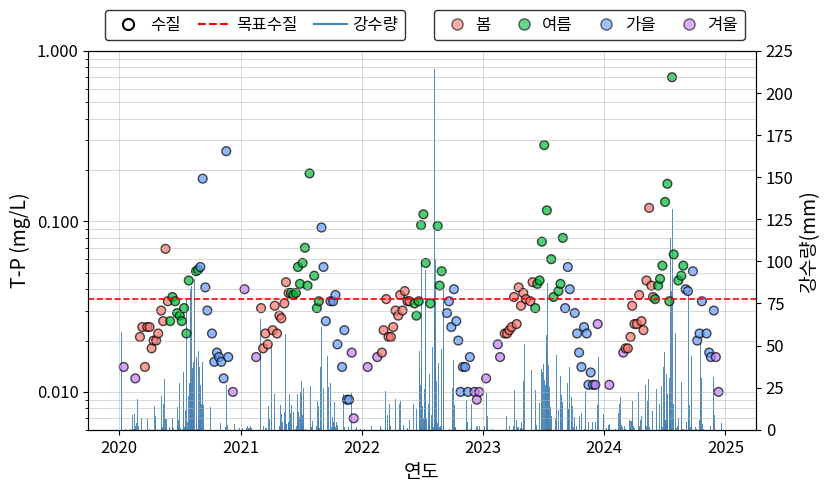

In [218]:
## 강수 / 수질(T-P) 그래프

# 한글 폰트 지정
plt.rcParams['font.family'] = 'Noto Sans KR'

# 데이터 준비
데이터 = 총량측정망_기상.copy()
데이터['일자'] = pd.to_datetime(데이터['일자'])
데이터 = 데이터[데이터['연도'] >= 2020]

# 🎨 계절별 색상 지정
season_palette = {
    '봄': '#F8766D',
    '여름': '#00BA38',
    '가을': '#619CFF',
    '겨울': '#C77CFF'
}
season_colors = 데이터['계절'].map(season_palette)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(8.4, 5))
ax2 = ax1.twinx()  # 보조 y축 생성

# 🔵 강수량 막대 그래프
ax2.bar(
    데이터['일자'], 데이터['일강수량'],
    width=3, color='steelblue', alpha=0.9, label='강수량'
)
ax2.set_ylim(0, 225)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))  # y축 레이블 포맷팅(x를 정수로 변환하고, 천 단위 쉼표 추가)
ax2.grid(False)

# ⚫ 수질 점
scatter = ax1.scatter(
    데이터['일자'], 데이터['TP'],
    c=season_colors, edgecolor='black', s=40,
    label='수질(TP)', alpha=0.7
)
ax1.set_yscale("log")
ax1.set_ylim(0.006, 1)
# y축 로그 스케일 유지하되 눈금은 일반 숫자로
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.ticklabel_format(axis='y', style='plain')
ax1.xaxis.set_major_locator(mdates.YearLocator())  # 연도 단위로 x축 눈금 설정
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도 형식으로 표시
ax1.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.7)  # 격자선 설정

# 🔴 목표수질 선
ax1.axhline(y=목표수질_TP, color='red', linestyle='dashed', linewidth=1.2, label='목표수질')

# 📌 축 레이블 제목 설정
ax1.set_xlabel("연도", fontsize=14)
ax1.set_ylabel("T-P (mg/L)", fontsize=14)
ax2.set_ylabel("강수량(mm)", fontsize=14)

# 축 눈금 설정
ax1.tick_params(axis='both', labelsize=12)  # x축 + 왼쪽 y축
ax2.tick_params(axis='y', labelsize=12)     # 오른쪽 y축

# ax2의 zorder를 얻고, ax2의 zorder보다 큰 값을 ax1의 zorder로 지정
# zorder가 낮을수록 먼저 그려지고, zorder가 높을수록 나중에 그려짐
ax1.set_zorder(ax2.get_zorder() + 10)
# ax1의 배경을 투명하게 만들어 ax1이 앞으로 배치되었을 때 ax2의 내용이 가려지지 않게 함
ax1.patch.set_visible(False)

# 범례 요소 구성
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', 
               color='black', markerfacecolor='white', 
               label='수질', markersize=8, markeredgewidth=1.5),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질'),
    plt.Line2D([0], [0], linestyle='-', color='steelblue', label='강수량')
] + [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor=color, alpha=0.6, label=label, markersize=8)
    for label, color in season_palette.items()
]

# 1️⃣ 수질 / 목표수질 / 유량 범례
legend1 = ax1.legend(
    handles=legend_handles[:3],  # 앞 3개: 수질, 목표수질, 강수량
    loc='upper center',
    ncol=3,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.25, 1.13),
    fontsize=12,
    handletextpad=0.3,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 2️⃣ 계절 범례 (제목 포함)
legend2 = ax1.legend(
    handles=legend_handles[3:],  # 뒤 4개: 봄~겨울
    loc='upper center',
    ncol=4,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.75, 1.13),
    fontsize=12,
    title_fontsize=12,
    handletextpad=0.1,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 첫 번째 범례를 그래프에 추가로 다시 등록
ax1.add_artist(legend1)

# 상단 여백 확보
plt.subplots_adjust(top=0.82)
plt.tight_layout()
plt.show()


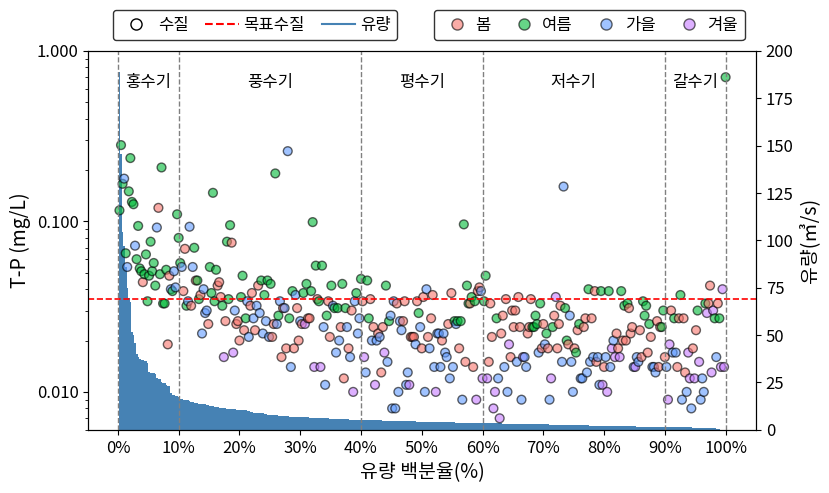

In [217]:
## 유량 / 수질(T-P) 그래프

# 한글 폰트 지정
plt.rcParams['font.family'] = 'Noto Sans KR'

# 데이터 준비
데이터 = 총량측정망.copy()

# 🎨 계절별 색상 지정
season_palette = {
    '봄': '#F8766D',
    '여름': '#00BA38',
    '가을': '#619CFF',
    '겨울': '#C77CFF'
}
season_colors = 데이터['계절'].map(season_palette)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(8.4, 5))
ax2 = ax1.twinx()  # 보조 y축 생성

# 🔵 유량 막대
bars = ax2.bar(
    데이터['유량백분율'], 데이터['유량'],
    width=0.3, color='steelblue', alpha=1,
    label='유량'
)
ax2.set_ylim(0, 200)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))  # y축 레이블 포맷팅(x를 정수로 변환하고, 천 단위 쉼표 추가)

# ⚫ 수질 점
scatter = ax1.scatter(
    데이터['유량백분율'], 데이터['TP'],
    c=season_colors, edgecolor='black', s=40,
    alpha=0.6, label='수질'
)
ax1.set_yscale("log")
ax1.set_ylim(0.006, 1)
# y축 로그 스케일 유지하되 눈금은 일반 숫자로
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xticks(range(0, 101, 10))  # x축 눈금 설정
ax1.set_xticklabels([f"{x}%" for x in range(0, 101, 10)])  # x축 레이블 설정

# 🔴 목표수질 선
ax1.axhline(y=목표수질_TP, color='red', linestyle='dashed', linewidth=1.2, label='목표수질')

# 🔲 수직선 (유황구간 기준선)
for x in [0, 10, 40, 60, 90, 100]:
    ax1.axvline(x=x, linestyle='dashed', linewidth=1, color='gray')

# 📝 유황구간 라벨
유황라벨 = {
    5: '홍수기', 25: '풍수기', 50: '평수기',
    75: '저수기', 95: '갈수기'
}
for x, label in 유황라벨.items():
    ax1.text(x, 0.65, label, ha='center', va='center', fontsize=12)

# 📌 축 레이블 제목 설정
ax1.set_xlabel("유량 백분율(%)", fontsize=14)
ax1.set_ylabel("T-P (mg/L)", fontsize=14)
ax2.set_ylabel("유량(㎥/s)", fontsize=14)

# 축 눈금 설정
ax1.tick_params(axis='both', labelsize=12)  # x축 + 왼쪽 y축
ax2.tick_params(axis='y', labelsize=12)     # 오른쪽 y축


# ax2의 zorder를 얻고, ax2의 zorder보다 큰 값을 ax1의 zorder로 지정
# zorder가 낮을수록 먼저 그려지고, zorder가 높을수록 나중에 그려짐
ax1.set_zorder(ax2.get_zorder() + 10)
# ax1의 배경을 투명하게 만들어 ax1이 앞으로 배치되었을 때 ax2의 내용이 가려지지 않게 함
ax1.patch.set_visible(False)

# 📌 범례 구성 (수질/목표수질/유량 + 계절)
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None',
               color='black', markerfacecolor='white', label='수질', markersize=8),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질'),
    plt.Line2D([0], [0], linestyle='-', color='steelblue', label='유량')
] + [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor=color, alpha=0.6, label=label, markersize=8)
    for label, color in season_palette.items()
]

# 1️⃣ 수질 / 목표수질 / 유량 범례
legend1 = ax1.legend(
    handles=legend_handles[:3],  # 앞 3개: 수질, 목표수질, 유량
    loc='upper center',
    ncol=3,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.25, 1.13),
    fontsize=12,
    handletextpad=0.3,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 2️⃣ 계절 범례 (제목 포함)
legend2 = ax1.legend(
    handles=legend_handles[3:],  # 뒤 4개: 봄~겨울
    loc='upper center',
    ncol=4,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.75, 1.13),
    fontsize=12,
    title_fontsize=12,
    handletextpad=0.1,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 첫 번째 범례를 그래프에 추가로 다시 등록
ax1.add_artist(legend1)

# 여백 조정
plt.subplots_adjust(top=0.82)
plt.tight_layout()
plt.show()


C:\Users\TG\AppData\Local\Temp\ipykernel_7028\2987190414.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


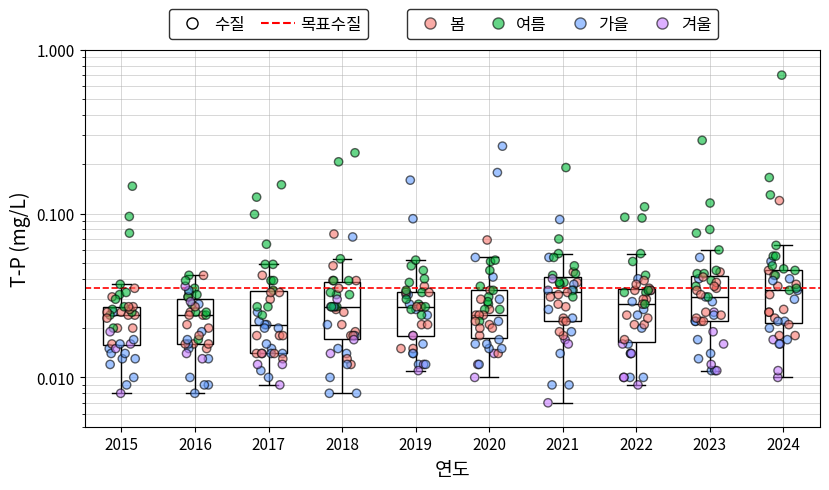

In [219]:
## 연도 별 박스플롯

# 한글 폰트 지정
plt.rcParams['font.family'] = 'Noto Sans KR'

# 데이터 준비
데이터 = 총량측정망.copy()
데이터 = 데이터[데이터['TP'] > 0]  # 로그 스케일이므로 0 이상만 사용

# 🎨 계절별 색상 지정
season_palette = {
    '봄': '#F8766D',
    '여름': '#00BA38',
    '가을': '#619CFF',
    '겨울': '#C77CFF'
}
season_colors = 데이터['계절'].map(season_palette)

# 그래프 생성
fig, ax = plt.subplots(figsize=(8.4, 5))

# 📦 박스플롯 (이상치 표시 없이)
sns.boxplot(
    data=데이터, x='연도', y='TP',
    ax=ax, showfliers=False, width=0.5,
    color='white', linewidth=1,
    linecolor='black'
)

# ⚫ Jittered scatter
sns.stripplot(
    data=데이터, x='연도', y='TP',
    ax=ax, 
    jitter=0.2,  # 점들이 겹치지 않도록 약간의 무작위 이동
    size=6,
    edgecolor='black',
    linewidth=1,
    palette=season_palette,
    hue='계절',
    dodge=False,  # 계절별로 점을 분리하지 않음
    alpha=0.6, marker='o'
)

# 🔴 목표수질 수평선
ax.axhline(y=목표수질_TP, color='red', linestyle='--', linewidth=1.2, label='목표수질')

# 🧪 y축 로그 스케일
ax.set_yscale("log")
ax.set_ylim(0.005, 1)
# y축 로그 스케일 유지하되 눈금은 일반 숫자로
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y', style='plain')
ax.set_ylabel("T-P (mg/L)", fontsize=14)
ax.set_xlabel("연도", fontsize=14)
ax.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.7)  # 격자선 설정

# 🎯 범례 수동 구성
legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor='white', label='수질', markersize=8),
    plt.Line2D([0], [0], linestyle='--', color='red', label='목표수질')
] + [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', 
               markerfacecolor=color, alpha=0.6, label=label, markersize=8)
    for label, color in season_palette.items()
]

# 1️⃣ 수질 / 목표수질 / 유량 범례
legend1 = ax.legend(
    handles=legend_handles[:2],  # 앞 2개: 수질, 목표수질
    loc='upper center',
    ncol=2,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.25, 1.13),
    fontsize=12,
    handletextpad=0.3,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 2️⃣ 계절 범례 (제목 포함)
legend2 = ax.legend(
    handles=legend_handles[2:],  # 뒤 4개: 봄~겨울
    loc='upper center',
    ncol=4,
    frameon=True,  # 범례 테두리 표시
    edgecolor='black',  # 범례 테두리 색상
    bbox_to_anchor=(0.65, 1.13),
    fontsize=12,
    title_fontsize=12,
    handletextpad=0.1,  # 범례 마커와 텍스트 간 간격
    columnspacing=1   # 범례 항목(열) 간 간격
)

# 첫 번째 범례를 그래프에 추가로 다시 등록
ax.add_artist(legend1)

# 🎨 기타 스타일
ax.tick_params(labelsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title("")  # 제목 없음

plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()